In [79]:
import copy

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis
from torchvision.transforms import v2
import torch.nn.utils.prune as prune
import onnx


In [80]:
print(torch.cuda.is_available())

True


In [131]:
# run variables

seed = 42
file_name = 'base_pruned'
# file_name = 'student_self_taught'

class BaseNN(nn.Module):
    def __init__(self, conv1_out = 128, conv2_out = 64, conv3_out = 32, num_classes=10):
        super(BaseNN, self).__init__()

        ### teacher
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv2_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv3_out * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [82]:
# device settings

num_workers = 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

NVIDIA GeForce RTX 2060
Using cuda device


In [83]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified
train set size: 40000
validation set size: 10000
test set size: 10000


In [84]:
def train(model, epochs, learning_rate):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        trainingEpoch_loss.append(running_loss / len(train_loader))

        # validation
        model.eval()
        validation_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(validation_loader))

    return trainingEpoch_loss, validationEpoch_loss

In [87]:

def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [86]:
torch.manual_seed(seed)
model_base = BaseNN(num_classes=10).to(device)


In [88]:
trainingEpoch_loss, validationEpoch_loss = train(model_base, epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 1.3680790350914
Epoch 2/10, Loss: 0.9080827822685241
Epoch 3/10, Loss: 0.7026727115631104
Epoch 4/10, Loss: 0.5401674045801163
Epoch 5/10, Loss: 0.4019766563415527
Epoch 6/10, Loss: 0.28280955748558045
Epoch 7/10, Loss: 0.2190617665708065
Epoch 8/10, Loss: 0.1727651247471571
Epoch 9/10, Loss: 0.15302276037931442
Epoch 10/10, Loss: 0.12898654088824987


In [89]:
test(model_base)

Test Accuracy: 72.11%


72.11

In [90]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [91]:
total, trainable = count_parameters(model_base)

print(f"📦 Liczba wszystkich parametrów: {total}")

📦 Liczba wszystkich parametrów: 1186986


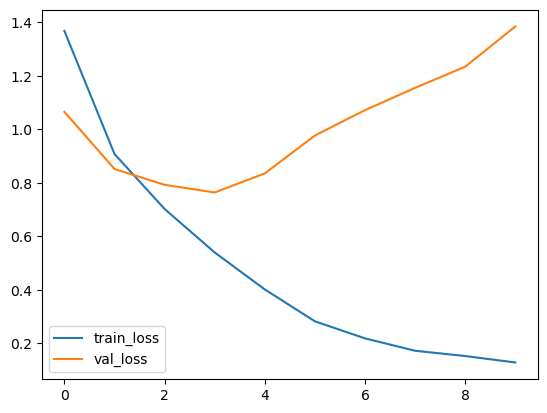

In [92]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [94]:
# === Sparsity ===
def calculate_sparsity(model):
    zero, total = 0, 0
    for p in model.parameters():
        total += p.numel()
        zero += (p == 0).sum().item()
    return 100.0 * zero / total

In [95]:
# === Unstructured pruning ===
unstructured_model = copy.deepcopy(model_base)
prune.l1_unstructured(unstructured_model.classifier[0], name='weight', amount=0.9)
prune.l1_unstructured(unstructured_model.classifier[3], name='weight', amount=0.9)

prune.l1_unstructured(unstructured_model.features[0], name='weight', amount=0.9)
prune.l1_unstructured(unstructured_model.features[2], name='weight', amount=0.9)


Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [96]:
trainingEpoch_loss, validationEpoch_loss = train(unstructured_model, epochs=7, learning_rate=0.0001)

Epoch 1/7, Loss: 1.6281987529754638
Epoch 2/7, Loss: 0.8702598644256592
Epoch 3/7, Loss: 0.681368865776062
Epoch 4/7, Loss: 0.5888709562778472
Epoch 5/7, Loss: 0.5315017437934876
Epoch 6/7, Loss: 0.48798484754562377
Epoch 7/7, Loss: 0.4521580106019974


In [97]:
test(unstructured_model)

Test Accuracy: 70.33%


70.33

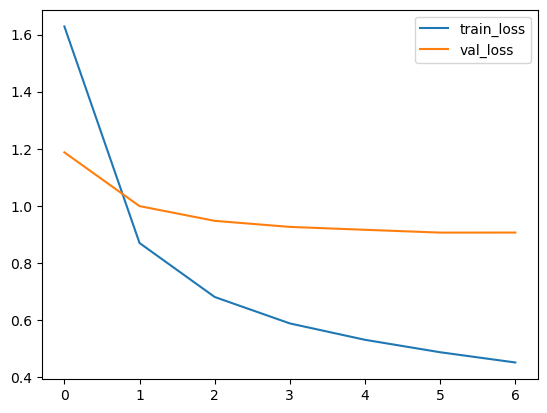

In [98]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [99]:
def count_nonzero_parameters(model):
    total_nonzero = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_nonzero += (param != 0).sum().item()
    return total_nonzero

In [100]:
total, trainable = count_parameters(unstructured_model)

print(f"📦 Liczba wszystkich parametrów: {total}")

📦 Liczba wszystkich parametrów: 1186986


In [101]:
print(f"Sparsity: {calculate_sparsity(unstructured_model):.2f}%")

# === Usuwanie masek pruningowych ===
for module in [unstructured_model.classifier[0], unstructured_model.classifier[3], unstructured_model.features[0], unstructured_model.features[2]]:
    prune.remove(module, 'weight')

print(f"Sparsity: {calculate_sparsity(unstructured_model):.2f}%")

Sparsity: 0.00%
Sparsity: 85.75%


In [102]:
zeros_weight_count = count_nonzero_parameters(unstructured_model)
print(f"📦 Liczba niezerowych parametrów: {zeros_weight_count}")

📦 Liczba niezerowych parametrów: 168385


In [103]:
torch.save(unstructured_model.state_dict(), "../models/" + "unstructured_model" + ".pt")

In [105]:
dummy_input = torch.randn(1, 3, 32, 32, dtype=torch.float32).to(device)

torch.onnx.export(model_base, dummy_input, "model_base.onnx",
                  input_names=["input"], output_names=["output"], opset_version=11,
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

torch.onnx.export(unstructured_model, dummy_input, "model_sparse.onnx",
                  input_names=["input"], output_names=["output"], opset_version=11,
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

In [106]:
#from deepsparse import Engine
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import time

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = datasets.CIFAR10(root='./../data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

engine_base = Engine("model_base.onnx")
engine_sparse = Engine("model_sparse.onnx")

def run_inference(engine, dataloader, max_batches=1000):
    engine_outputs = []
    total_time = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        if i >= max_batches:
            break
        inputs_np = inputs.numpy()
        start = time.time()
        outputs = engine.run([inputs_np])
        end = time.time()
        total_time += (end - start)
        engine_outputs.append(outputs[0])
    avg_time = total_time / max_batches
    return avg_time

# Pomiar czasu inferencji
base_time = run_inference(engine_base, test_loader)
sparse_time = run_inference(engine_sparse, test_loader)

print(f"Average inference time per sample (base model): {base_time:.6f} s")
print(f"Average inference time per sample (sparse model): {sparse_time:.6f} s")

In [107]:
import onnxruntime as ort
import numpy as np
import torch

In [108]:
def run_inference_onnx(sess, loader, max_samples=1000):
    times = []
    import time
    for i, (images, labels) in enumerate(loader):
        if i >= max_samples:
            break
        input_array = images.numpy()
        input_name = sess.get_inputs()[0].name
        start = time.time()
        outputs = sess.run(None, {input_name: input_array})
        end = time.time()
        times.append(end - start)
    avg_time = np.mean(times)
    return avg_time

In [109]:
sess_base = ort.InferenceSession("model_base.onnx")
sess_sparse = ort.InferenceSession("model_sparse.onnx")

avg_time_base = run_inference_onnx(sess_base, test_loader, max_samples=1000)
avg_time_sparse = run_inference_onnx(sess_sparse, test_loader, max_samples=1000)

print(f"Base ONNX: {avg_time_base:.6f} s/sample")
print(f"Sparse ONNX: {avg_time_sparse:.6f} s/sample")

Base ONNX: 0.027014 s/sample
Sparse ONNX: 0.028614 s/sample


In [24]:
# === Structured pruning - kanały Conv2d ===
def get_pruned_channels(conv_layer, amount):
    weight = conv_layer.weight.detach().cpu()
    norms = weight.view(weight.size(0), -1).norm(p=2, dim=1)
    num_prune = int(amount * weight.size(0))
    keep_indices = torch.argsort(norms)[num_prune:]
    return keep_indices.tolist()

In [147]:
# Pruning 60% kanałów pierwszej i drugiej warstwy konwolucyjnej
keep1 = get_pruned_channels(model_base.features[0], amount=0.9)
keep2 = get_pruned_channels(model_base.features[2], amount=0.9)
keep3 = get_pruned_channels(model_base.features[5], amount=0.9)
structured_model = BaseNN(conv1_out=len(keep1), conv2_out= len(keep2), conv3_out=len(keep3)).to(device)

In [148]:
with torch.no_grad():
    # Conv1
    structured_model.features[0].weight.data = model_base.features[0].weight.data[keep1].clone()
    structured_model.features[0].bias.data = model_base.features[0].bias.data[keep1].clone()

    # Conv2 (wejście: keep1, wyjście: keep2)
    structured_model.features[2].weight.data = model_base.features[2].weight.data[keep2][:, keep1, :, :].clone()
    structured_model.features[2].bias.data = model_base.features[2].bias.data[keep2].clone()

    # Conv3 (wejście: keep2, wyjście: keep3)
    structured_model.features[5].weight.data = model_base.features[5].weight.data[keep3][:, keep2, :, :].clone()
    structured_model.features[5].bias.data = model_base.features[5].bias.data[keep3].clone()

    # Klasyfikator
    structured_model.classifier[0].weight.data = model_base.classifier[0].weight.data[:, :len(keep3) * 8 * 8].clone()
    structured_model.classifier[0].bias.data = model_base.classifier[0].bias.data.clone()

In [149]:
trainingEpoch_loss, validationEpoch_loss = train(structured_model, epochs=7, learning_rate=0.001)

Epoch 1/10, Loss: 1.4890573726654053
Epoch 2/10, Loss: 1.1344051064491272
Epoch 3/10, Loss: 1.0152961684226989
Epoch 4/10, Loss: 0.9364794162750244
Epoch 5/10, Loss: 0.8668711552619934
Epoch 6/10, Loss: 0.8001642560482025
Epoch 7/10, Loss: 0.7486680005550385
Epoch 8/10, Loss: 0.6968176655292511
Epoch 9/10, Loss: 0.6465922172546387
Epoch 10/10, Loss: 0.6050077926635742


In [150]:
test(structured_model)

Test Accuracy: 67.67%


67.67

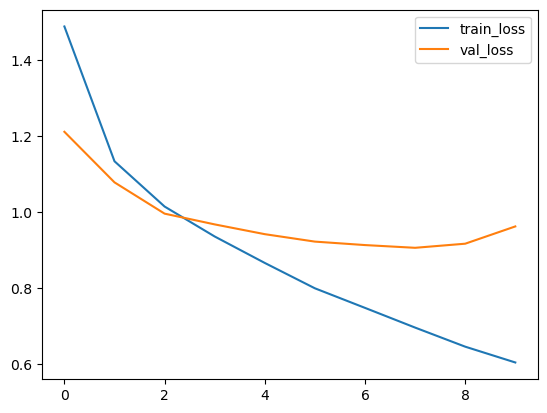

In [151]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [152]:
torch.save(structured_model.state_dict(), "../models/" + "structured_model" + ".pt")

In [153]:
# CIFAR-10: wejście 3x32x32
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# 2️⃣ Policz FLOPs per sample
flops_per_sample = FlopCountAnalysis(model_base, dummy_input).total()
print(f"GFLOPs per sample for base model: {flops_per_sample/10**6:.2f}")

flops_per_sample = FlopCountAnalysis(unstructured_model, dummy_input).total()
print(f"GFLOPs per sample for unstructured model: {flops_per_sample/10**6:.2f}")

flops_per_sample = FlopCountAnalysis(structured_model, dummy_input).total()
print(f"GFLOPs per sample for structured model: {flops_per_sample/10**6:.2f}")

Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)


GFLOPs per sample for base model: 94.25
GFLOPs per sample for unstructured model: 94.25
GFLOPs per sample for structured model: 1.66


In [155]:
import torch
import time
from codecarbon import EmissionsTracker

def measure_model(model, test_loader, device, num_samples=100):
    model.eval()
    model.to(device)

    tracker = EmissionsTracker()
    tracker.start()

    inference_times = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
            images = images.to(device)

            start = time.time()
            outputs = model(images)
            end = time.time()

            inference_times.append(end - start)

    emissions = tracker.stop()
    avg_latency = sum(inference_times) / len(inference_times)
    return avg_latency, emissions


# Pomiar dla trzech wersji modelu

device = "cuda" if torch.cuda.is_available() else "cpu"

base_model = BaseNN(num_classes=10).to(device)
base_model.load_state_dict(torch.load("../models/" + "base.pt"))

unstructured_model = BaseNN(num_classes=10).to(device)
unstructured_model.load_state_dict(torch.load("../models/" + "unstructured_model.pt"))

structured_model = BaseNN(num_classes=10, conv1_out = len(keep1), conv2_out = len(keep2), conv3_out=len(keep3)).to(device)
structured_model.load_state_dict(torch.load("../models/" + "structured_model.pt"))

avg_latency_base, emissions_base = measure_model(base_model, test_loader, device)
avg_latency_unstruct, emissions_unstruct = measure_model(unstructured_model, test_loader, device)
avg_latency_struct, emissions_struct = measure_model(structured_model, test_loader, device)

# --------------------------------------------------
# Wyniki

print("\n=== Wyniki pomiarów ===")
print(f"Base Model       -> Latency: {avg_latency_base:.6f}s/{test_loader.batch_size}, Emisje CO₂: {emissions_base:.8f} kg")
print(f"Unstructured Pr. -> Latency: {avg_latency_unstruct:.6f}s/{test_loader.batch_size}, Emisje CO₂: {emissions_unstruct:.8f} kg")
print(f"Structured Pr.   -> Latency: {avg_latency_struct:.6f}s/{test_loader.batch_size}, Emisje CO₂: {emissions_struct:.8f} kg")


C:\Users\Adam\AppData\Local\Temp\ipykernel_6824\948222283.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("../models/" + "base.pt"


=== Wyniki pomiarów ===
Base Model       -> Latency: 0.001377s/64, Emisje CO₂: 0.00071395 kg
Unstructured Pr. -> Latency: 0.001367s/64, Emisje CO₂: 0.00071802 kg
Structured Pr.   -> Latency: 0.001302s/64, Emisje CO₂: 0.00067336 kg


In [156]:
import os

size_MB_base = os.path.getsize("../models/base.pt") / (1024 * 1024)
size_MB_unstructured = os.path.getsize("../models/unstructured_model.pt") / (1024 * 1024)
size_MB_structured = os.path.getsize("../models/structured_model.pt") / (1024 * 1024)
print(f"Base model size: {size_MB_base:.2f} MB")
print(f"Unstructured model size: {size_MB_unstructured:.2f} MB")
print(f"Structured model size: {size_MB_structured:.2f} MB")

Base model size: 4.53 MB
Unstructured model size: 4.53 MB
Structured model size: 0.91 MB
